# Implementing a Recommender System using LightGCN

In [43]:
import matplotlib.pyplot as plt
from modeling.sampling import sample_minibatch_V2
from modeling.metrics import calculate_metrics
from modeling.losses import BPR_loss
import torch_geometric.transforms as T 
from torch_geometric.data import Data, HeteroData

import time

import torch
from torch import optim

In [44]:
# Lets start by loading the data
data = torch.load("data/hetero_data_no_coauthor.pt", weights_only=False)
assert data.is_undirected(), "Data should be undirected"
data["author"].x = torch.ones((data["author"].num_nodes, 256))

print(data)

HeteroData(
  author={
    node_id=[90941],
    x=[90941, 256],
  },
  paper={
    node_id=[63854],
    x=[63854, 256],
  },
  (author, writes, paper)={ edge_index=[2, 320187] },
  (paper, rev_writes, author)={ edge_index=[2, 320187] }
)


In [45]:
# Splitting the data
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    disjoint_train_ratio=0.3,
    add_negative_train_samples=False,
    is_undirected=True,
    edge_types=[("author", "writes", "paper")],
    rev_edge_types=[("paper", "rev_writes", "author")],
)(data)


In [46]:
from torch_geometric.nn import to_hetero
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch_geometric.nn.conv import SAGEConv


class GNN(torch.nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        num_layers: int,
    ):
        super().__init__()

        self.convs = torch.nn.ModuleList(
            [
                SAGEConv(
                    embedding_dim,
                    embedding_dim,
                    aggr="mean",
                    project=True,
                    normalize=True,
                )
                for _ in range(num_layers - 1)
            ]
        )

        self.out_conv = SAGEConv(
            embedding_dim,
            embedding_dim,
            aggr="mean",
            project=False,
        )

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        return self.out_conv(x, edge_index)


class Model(torch.nn.Module):
    def __init__(
        self,
        input_dim: int = 256,
        embedding_dim: int = 256,
        output_dim: int = 256,
        num_layers: int = 5,
    ):
        super().__init__()

        self.embedding_dim = embedding_dim

        self.gnn = GNN(embedding_dim, num_layers)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(
            self.gnn,
            metadata=data.metadata(),
            aggr="sum",
        )
        
        # self.author_input_projection = torch.nn.Linear(input_dim, embedding_dim)
        # self.paper_input_projection = torch.nn.Linear(input_dim, embedding_dim)
        
        # self.author_output_projection = torch.nn.Linear(embedding_dim, output_dim)
        # self.paper_output_projection = torch.nn.Linear(embedding_dim, output_dim)
        

    def forward(self, data: HeteroData) -> torch.Tensor:

        x_dict = {
            "author": data["author"].x,
            "paper": data["paper"].x,
        }
        
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        

        
        return x_dict

In [47]:
# define contants
ITERATIONS = 10000
LR = 1e-3

ITERS_PER_EVAL = 1000
K = 20

BATCH_SIZE = 4096
NEG_SAMPLE_RATIO = 100

TEST_EDGE_TYPE = ("author", "writes", "paper")

# setup
model = Model(
    embedding_dim=256,
    num_layers=3,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}.")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)

# training loop
train_losses = []
batching_times = []
forward_times = []
loss_times = []
backward_times = []

Using device cuda.


In [48]:

for iter in range(ITERATIONS):
    print(
        f"Iteration {iter + 1}/{ITERATIONS} | Average Loss over last 100 iters: {sum(train_losses[-100:])/len(train_losses[-100:]) if len(train_losses) > 0 else 0:.5f}",
        end="\r",
    )

    # mini batching
    start_time = time.time()
    sampled_author_ids, sampled_pos_paper_ids, sampled_neg_paper_ids = (
        sample_minibatch_V2(
            data=train_data,
            edge_type=TEST_EDGE_TYPE,
            batch_size=BATCH_SIZE,
            neg_sample_ratio=NEG_SAMPLE_RATIO,
        )
    )
    batching_times.append(time.time() - start_time)

    # forward propagation
    start_time = time.time()
    embeddings = model.forward(train_data)
    author_embeddings = embeddings["author"]
    paper_embeddings = embeddings["paper"]
    forward_times.append(time.time() - start_time)

    pos_scores = torch.sum(
        author_embeddings[sampled_author_ids] * paper_embeddings[sampled_pos_paper_ids],
        dim=1,
    )
    neg_scores = torch.sum(
        author_embeddings[sampled_author_ids] * paper_embeddings[sampled_neg_paper_ids],
        dim=1,
    )

    # loss computation
    start_time = time.time()
    train_loss = BPR_loss(pos_scores, neg_scores)
    loss_times.append(time.time() - start_time)

    # backward propagation
    start = time.time()
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    backward_times.append(time.time() - start)

    train_losses.append(train_loss.item())

    if (iter + 1) % ITERS_PER_EVAL == 0:
        model.eval()

        train_edge_index = train_data[TEST_EDGE_TYPE].edge_index
        train_edge_label_index = train_data[TEST_EDGE_TYPE].edge_label_index
        
        val_edge_label_index = val_data[TEST_EDGE_TYPE].edge_label_index


        with torch.no_grad():
            # typically we would use the supervising edges as well here
            # But LightGCN does not have parameters, it only learns from the edges we use during training is is fix after that
            embeddings = model.forward(val_data)
            author_embeddings = embeddings["author"]
            paper_embeddings = embeddings["paper"]


        val_recall, val_precision = calculate_metrics(
            author_embeddings,
            paper_embeddings,
            val_edge_label_index,
            [train_edge_index, train_edge_label_index],
            k=K,
        )
        
        with torch.no_grad():
            # typically we would use the supervising edges as well here
            # But LightGCN does not have parameters, it only learns from the edges we use during training is is fix after that
            embeddings = model.forward(train_data)
            author_embeddings = embeddings["author"]
            paper_embeddings = embeddings["paper"]
            
        train_recall, train_precision = calculate_metrics(
            author_embeddings,
            paper_embeddings,
            train_edge_label_index,
            [train_edge_index],
            k=K,
        )

        print(
            f"[Iteration {iter + 1}/{ITERATIONS}] train_loss: {train_loss.item():.05f}, val_recall@{K}: {val_recall:.05f}, val_precision@{K}: {val_precision:.05f}, train_recall@{K}: {train_recall:.05f}, train_precision@{K}: {train_precision:.05f}"
        )
        model.train()

# Best layer = 8: [Iteration 10000/10000] train_loss: 0.08947, val_recall@20: 0.02844, val_precision@20: 0.00221, train_recall@20: 0.03590, train_precision@20: 0.00380
#               [Iteration 100000/100000] train_loss: 0.03324, val_recall@20: 0.07191, val_precision@20: 0.00573, train_recall@20: 0.26362, train_precision@20: 0.02820
#                 [Iteration 10000/10000] train_loss: 0.01416, val_recall@20: 0.04928, val_precision@20: 0.00365, train_recall@20: 0.68624, train_precision@20: 0.06235

[Iteration 1000/10000] train_loss: 0.15042, val_recall@20: 0.00227, val_precision@20: 0.00018, train_recall@20: 0.00171, train_precision@20: 0.00018
[Iteration 2000/10000] train_loss: 0.08225, val_recall@20: 0.00225, val_precision@20: 0.00016, train_recall@20: 0.00139, train_precision@20: 0.00014


KeyboardInterrupt: 

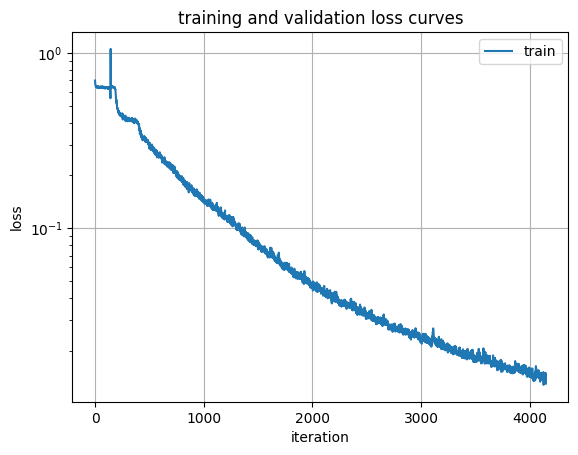

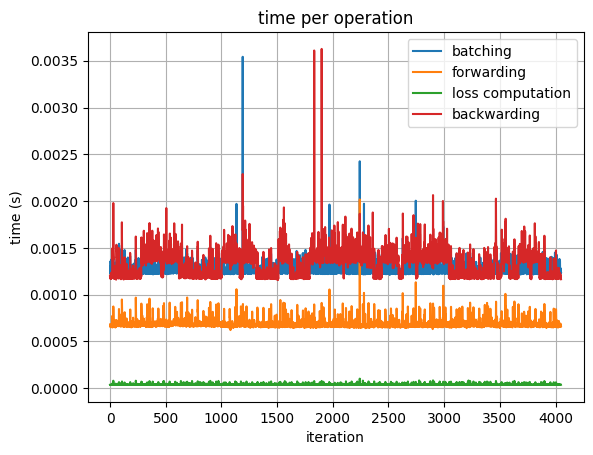

In [ ]:
# save the train_loss curve
plt.plot(train_losses, label="train")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("training and validation loss curves")
plt.legend()
plt.grid()
plt.yscale("log")
# plt.xscale("log")
plt.savefig("training_loss_curve.png")
plt.show()

plt.plot(batching_times[100:], label="batching")
plt.plot(forward_times[100:], label="forwarding")
plt.plot(loss_times[100:], label="loss computation")
plt.plot(backward_times[100:], label="backwarding")
plt.xlabel("iteration")
plt.ylabel("time (s)")
plt.title("time per operation")
plt.legend()
plt.grid()
plt.show()

In [62]:

sampled_author_ids, sampled_pos_paper_ids, sampled_neg_paper_ids = (
    sample_minibatch_V2(
        data=train_data,
        edge_type=TEST_EDGE_TYPE,
        batch_size=1,
        neg_sample_ratio=NEG_SAMPLE_RATIO,
    )
)

with torch.no_grad():
    # typically we would use the supervising edges as well here
    # But LightGCN does not have parameters, it only learns from the edges we use during training is is fix after that
    embeddings = model.forward(train_data)
    author_embeddings = embeddings["author"]
    paper_embeddings = embeddings["paper"]

pos_scores = torch.sum(
    author_embeddings[sampled_author_ids] * paper_embeddings[sampled_pos_paper_ids],
    dim=1,
)
neg_scores = torch.sum(
    author_embeddings[sampled_author_ids] * paper_embeddings[sampled_neg_paper_ids],
    dim=1,
)

loss = BPR_loss(pos_scores, neg_scores)

print(f"Final BPR loss on training data: {loss.item():.5f}")

Final BPR loss on training data: 0.09660


In [63]:
torch.sort(pos_scores - neg_scores)[0]

tensor([-3.0072, -2.4398, -1.0467, -0.2915,  0.2643,  0.5768,  1.8910,  2.1200,
         2.1756,  2.2970,  2.5849,  3.1144,  3.1843,  3.1940,  3.3555,  3.4675,
         3.8851,  3.9573,  4.3662,  4.4413,  4.4555,  4.6639,  4.7006,  4.9108,
         4.9606,  5.1203,  5.2672,  5.4824,  5.9102,  6.0119,  6.0242,  6.0588,
         6.1010,  6.1065,  6.4867,  6.5813,  6.6521,  6.6606,  6.7333,  7.1024,
         7.1206,  7.2238,  7.2982,  7.3279,  7.5017,  8.5045,  8.6151,  8.7815,
         8.8883,  9.0358,  9.0961,  9.1277,  9.4411,  9.6743, 10.2756, 10.4049,
        10.7119, 10.8141, 11.3540, 11.5305, 12.1742, 12.8388, 12.8521, 12.8999,
        12.9335, 13.0590, 13.0967, 13.5766, 13.6147, 13.9781, 14.6769, 14.7075,
        14.7661, 15.2242, 15.7249, 15.8148, 16.2505, 16.8544, 17.4896, 18.0504,
        18.1294, 18.3630, 18.7405, 19.0140, 19.3278, 19.7967, 20.0963, 20.1332,
        20.4335, 20.8768, 21.5039, 23.4803, 24.1173, 24.5643, 25.0607, 25.9134,
        26.3539, 26.8605, 27.8620, 28.57

In [ ]:
K = 20000

train_recall, train_precision = calculate_metrics(
    author_embeddings,
    paper_embeddings,
    train_edge_label_index,
    [train_edge_index],
    k=K,
)

print(f"Final train recall@{K}: {train_recall:.5f}, precision@{K}: {train_precision:.5f}")